Plotting pairwise relationships for selected features...


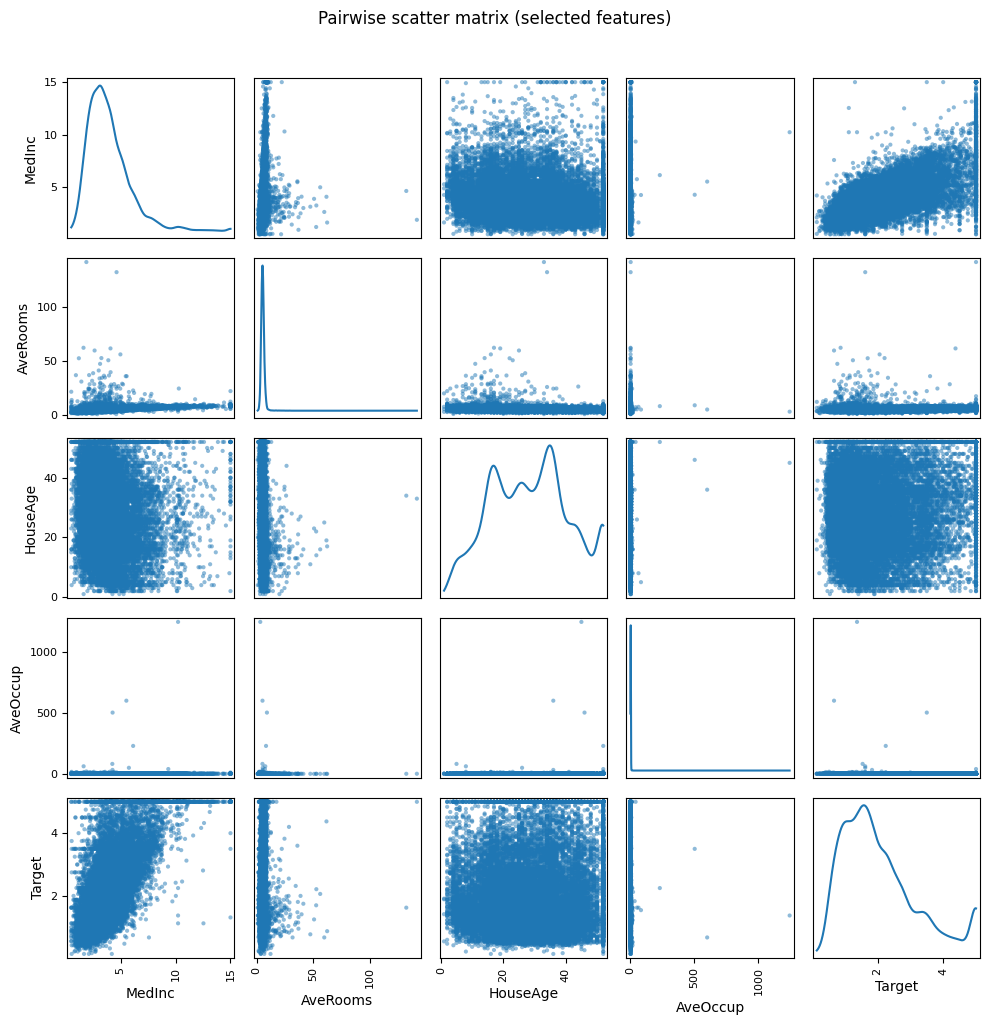

Original shape: (20640, 8), After polynomial expansion: (20640, 44)
Iter=200, LR=0.100 | R²=0.8441 | RMSE=0.4511
Iter=250, LR=0.100 | R²=0.8478 | RMSE=0.4457
Iter=350, LR=0.100 | R²=0.8392 | RMSE=0.4581
Iter=200, LR=0.050 | R²=0.8394 | RMSE=0.4578
Iter=250, LR=0.050 | R²=0.8427 | RMSE=0.4531
Iter=350, LR=0.050 | R²=0.8440 | RMSE=0.4512
Iter=200, LR=0.001 | R²=0.2205 | RMSE=1.0087
Iter=250, LR=0.001 | R²=0.2627 | RMSE=0.9810
Iter=350, LR=0.001 | R²=0.3408 | RMSE=0.9276

Best model: {'path': 'models/model_iter250_lr0_1.joblib', 'learning_rate': 0.1, 'max_iter': 250, 'r2': 0.8478221299801938, 'rmse': 0.4456847077091418}


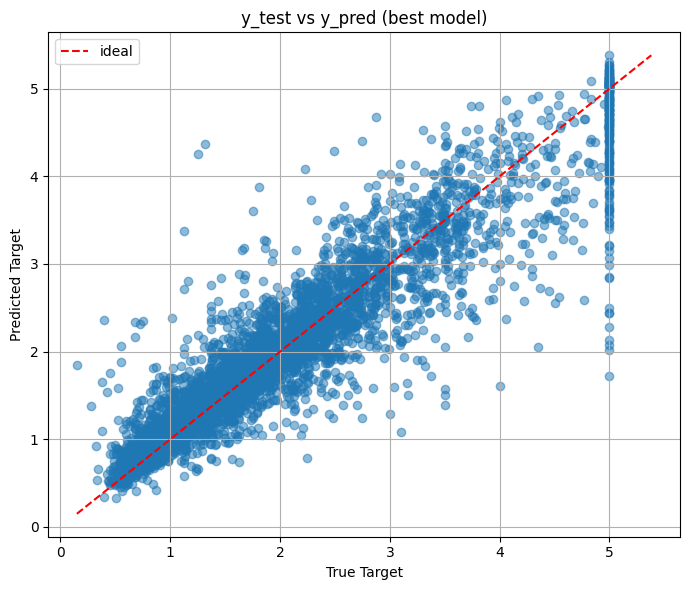

Saved training results summary to training_results_summary.csv


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt

from joblib import dump, load
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from pandas.plotting import scatter_matrix

# -----------------------------
# 1. Load dataset
# -----------------------------
housing = fetch_california_housing()
X = housing.data  # features
y = housing.target  # target

# Optional: convert to DataFrame for easier EDA plotting
df = pd.DataFrame(X, columns=housing.feature_names)
df["Target"] = y

# -----------------------------
# 2. Quick exploratory plots
#    (pairwise scatter for selected features)
# -----------------------------
selected = ["MedInc", "AveRooms", "HouseAge", "AveOccup", "Target"]
print("Plotting pairwise relationships for selected features...")
scatter_matrix(df[selected], alpha=0.5, figsize=(10, 10), diagonal="kde")
plt.suptitle("Pairwise scatter matrix (selected features)", y=1.02)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Feature expansion
# -----------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
print(f"Original shape: {X.shape}, After polynomial expansion: {X_poly.shape}")

# -----------------------------
# 4. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=432
)

# -----------------------------
# 5. Grid search over params
# -----------------------------

# prepare output dir and clear existing .joblib models
output_dir = Path("models")
output_dir.mkdir(parents=True, exist_ok=True)
for existing in output_dir.glob("*.joblib"):
    existing.unlink()

best_r2 = -float("inf")
best_model_info = None
results = []

for lr in [0.1, 0.05, 0.001]:
    for n_iter in [200, 250, 350]:
        model = HistGradientBoostingRegressor(max_iter=n_iter, learning_rate=lr)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = sqrt(mean_squared_error(y_test, y_pred))

        info = {
            "learning_rate": lr,
            "max_iter": n_iter,
            "r2": r2,
            "rmse": rmse,
        }
        results.append(info)

        print(f"Iter={n_iter}, LR={lr:.3f} | R²={r2:.4f} | RMSE={rmse:.4f}")

        # Save model into models/ folder
        safe_lr = str(lr).replace(".", "_")
        filename = output_dir / f"model_iter{n_iter}_lr{safe_lr}.joblib"
        dump(model, filename)

        # track best
        if r2 > best_r2:
            best_r2 = r2
            best_model_info = {
                "path": str(filename),
                "learning_rate": lr,
                "max_iter": n_iter,
                "r2": r2,
                "rmse": rmse,
            }

# -----------------------------
# 6. Plot predicted vs actual for best model
# -----------------------------
if best_model_info:
    print("\nBest model:", best_model_info)
    best_model = load(best_model_info["path"])
    y_pred_best = best_model.predict(X_test)

    plt.figure(figsize=(7, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.5)
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="ideal")
    plt.xlabel("True Target")
    plt.ylabel("Predicted Target")
    plt.title("y_test vs y_pred (best model)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7. Save summary of results to CSV for later analysis
# -----------------------------
results_df = pd.DataFrame(results).sort_values(by="r2", ascending=False)
results_df.to_csv("training_results_summary.csv", index=False)
print("Saved training results summary to training_results_summary.csv")